# Projeto de Machine Learning

O objetivo deste projeto é prever a nota da avaliação IMDb de um filme, estando disponíveis informações sobre plataforma de streaming, diretores, países, gêneros, entre outros. Os dados de análise foram retirados de: 
https://www.kaggle.com/ruchi798/movies-on-netflix-prime-video-hulu-and-disney

Adicionalmente, serão feitas análises relacionadas ao próprio desempenho do modelo, como por exemplo, removendo features importantes e analisar o quanto seu desempenho é afetado. 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Análise dos dados e pré-processamento

Antes de dar início às experimentações e testes com regressores, é importante avaliar e analisar os dados. Nesse caso, avalia-se a necessidade de uma feature para a análise e a presença de vazios no database.

In [27]:
rating_db = pd.read_csv("MoviesOnStreamingPlatforms_updated.csv")
rating_db.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [28]:
rating_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       16744 non-null  int64  
 1   ID               16744 non-null  int64  
 2   Title            16744 non-null  object 
 3   Year             16744 non-null  int64  
 4   Age              7354 non-null   object 
 5   IMDb             16173 non-null  float64
 6   Rotten Tomatoes  5158 non-null   object 
 7   Netflix          16744 non-null  int64  
 8   Hulu             16744 non-null  int64  
 9   Prime Video      16744 non-null  int64  
 10  Disney+          16744 non-null  int64  
 11  Type             16744 non-null  int64  
 12  Directors        16018 non-null  object 
 13  Genres           16469 non-null  object 
 14  Country          16309 non-null  object 
 15  Language         16145 non-null  object 
 16  Runtime          16152 non-null  float64
dtypes: float64(2

Como o objetivo é prever o IMDb a partir de outras características, elimina-se algumas colunas que não fazem sentido, como: "Unnamed: 0", "ID", "Rotten Tomatoes" (isso poderia ser uma trapaça), "Title". Além disso, os filmes cujo IMDb não é conhecido serão desconsiderados na análise. Por fim, analisa-se a coluna "Type":

In [29]:
rating_db.Type.value_counts()

0    16744
Name: Type, dtype: int64

Pois bem, como se trata de uma coluna só de zeros, elimina-se esta coluna da análise.

In [30]:
# Remoção de colunas desnecessárias
colunas = ["ID", "Title", "Rotten Tomatoes", "Type", "Unnamed: 0"]
rating_db = rating_db.drop(columns = colunas)

In [31]:
# Como o objetivo é prever o IMDb, linhas sem a informação não serão consideradas
rating_db = rating_db.dropna(subset=["IMDb"])
rating_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16173 entries, 0 to 16742
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         16173 non-null  int64  
 1   Age          7316 non-null   object 
 2   IMDb         16173 non-null  float64
 3   Netflix      16173 non-null  int64  
 4   Hulu         16173 non-null  int64  
 5   Prime Video  16173 non-null  int64  
 6   Disney+      16173 non-null  int64  
 7   Directors    15690 non-null  object 
 8   Genres       16072 non-null  object 
 9   Country      15955 non-null  object 
 10  Language     15801 non-null  object 
 11  Runtime      15819 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 1.6+ MB


Agora que o filtro inicial está feito, inicia-se uma análise mais profunda dos dados. Como já visto no database, existem colunas como Diretores, Gêneros, entre outros, que possuem mais de uma variável em uma célula. Isto é, existem, por exemplo, mais de um diretor por filme. É importante fazer uma análise levando em consideração a participação de cada diretor ao invés de um grupo de diretores. Existem ainda alguns diretores que participaram de somente um filme e, dessa forma, serão analisados como sendo "Outros Diretores". Esta mesma análise é feita para <i>Country</i> e <i>Language</i>.

In [32]:
#Separador por vírgulas
def splitter(x):
    try:
        return x.split(",")
    except:
        return []

#Lista todas as variáveis com suas respectivas aparições, incluindo casos com dois valores.
#Ex: 'Ademar, Bernardo' --> 'Ademar': 1; 'Bernardo': 1

def sorted_bom(x):
    return sorted(list(Counter(rating_db[x].apply(splitter).apply(pd.Series).unstack().reset_index(drop=True).dropna().values).items()),key = lambda x: -x[1])

In [33]:
# Não mexer:
# sorted(list(Counter(rating_db["Directors"].apply(splitter).apply(pd.Series).unstack().reset_index(drop=True).dropna().values).items()),key = lambda x: x[1])

In [34]:
# Conversão das classes com apenas uma contribuição, para uma categoria "outros":
def generaliza_valores(x, nome_coluna):
    class_per_movie = rating_db[x].apply(splitter).apply(pd.Series)
    all_class_contributions = sorted_bom(x)

    # Classes a serem trocadas
    others = []

    # Identificação das classes com apenas uma contribuição
    
    for classes, contributions in all_class_contributions:
        if int(contributions) < 2:
            others.append(classes)

    # Listando somente classes com mais de 2 contribuições
    official_classes = class_per_movie.replace(others, "Outros "+nome_coluna)
    
    construtor = list(official_classes.columns)
    rating_db[x] = official_classes[construtor].apply(lambda x: ','.join(x[x.notnull()]), axis = 1)

In [35]:
%%time

# Substituição de aparições individuais pela categoria "outros"
official_languages = generaliza_valores("Language", "Idiomas")
print("Idiomas ok")
official_directors = generaliza_valores("Directors", "Diretores")
print("Diretores ok")
official_countries = generaliza_valores("Country", "Paises")
print("Paises ok")

Idiomas ok
Diretores ok
Paises ok
Wall time: 2min 48s


In [77]:
# https://stackoverflow.com/questions/57469676/python-one-hot-encoding-for-comma-separated-values

Agora que se fazem disponíveis as categorias "outros" para diretores, idiomas e países, aplica-se um encoder para as colunas: <i>Directors</i>, <i>Genres</i>, <i>Languages</i>, <i>Age</i> e <i>Country</i>; uma vez que são variáveis categóricas e para que essas variáveis possam ser utilizadas no regressor. 

In [36]:
%%time

#Multiple One-Hot-Encoding
new_df = pd.concat([rating_db.drop('Language', 1), rating_db['Language'].str.get_dummies(sep=",")], 1)
print("Rodou 1 coluna")
new_df2 = pd.concat([new_df.drop('Directors', 1), new_df['Directors'].str.get_dummies(sep=",")], 1)
print("Rodou 2 colunas")
new_df3 = pd.concat([new_df2.drop('Genres', 1), new_df2['Genres'].str.get_dummies(sep=",")], 1)
print("Rodou 3 colunas")
new_df4 = pd.concat([new_df3.drop('Country', 1), new_df3['Country'].str.get_dummies(sep=",")], 1)
print("Rodou 4 colunas")
rating_db_OHE = pd.concat([new_df4.drop('Age', 1), new_df4['Age'].str.get_dummies(sep=",")], 1)
print("Rodou 5 colunas")

Rodou 1 coluna
Rodou 2 colunas
Rodou 3 colunas
Rodou 4 colunas
Rodou 5 colunas
Wall time: 51.8 s


In [79]:
# https://stackoverflow.com/questions/37646473/how-could-i-do-one-hot-encoding-with-multiple-values-in-one-cell
# pd.DataFrame({"diretor":pd.Series(['2','1','3']).astype('category',categories = [sorted_bom("Directors")])})

Com a aplicação da transformação das variáveis categóricas em números, basta preencher algumas informações na coluna <i>Runtime</i>. Esta será preenchida seguindo a técnica de mediana, a partir do SimpleImputer:

In [37]:
from sklearn.impute import SimpleImputer

#Preencher os valores vazios de RunTime, a partir da mediana da coluna
imputer = SimpleImputer(strategy="median")

#Treina o imputer
imputer.fit(rating_db_OHE[["Runtime"]])

#Adiciona os valores faltantes 
rating_db_OHE["Runtime"] = imputer.transform(rating_db_OHE[["Runtime"]])

In [83]:
# from sklearn.impute import SimpleImputer

# # Antes de treinar o SimpleImputer, remover a coluna de dados categóricos. O dataset resultante tem apenas
# # as variáveis independentes numéricas.
# rating_db_imputer = rating_db_OHE.copy()

# # Cria um imputer que substitui células inválidas (NaN) pela mediana dos valores da coluna à qual a célula pertence.
# imputer = SimpleImputer(strategy="median")

# # Agora treinar o Imputer. Isto vai causar o cálculo da mediana de cada coluna,
# # que ficará armazenado no Imputer para uso futuro.
# rating_db_imputer["Runtime"] = imputer.fit_transform(rating_db_imputer[["Runtime"]])

Com a construção e implementação do imputer, o database deve estar sem "nans":

In [38]:
rating_db_OHE.isnull().sum().sum()

0

Perfeito, não há mais valores nulos na tabela. Finaliza-se, assim, a etapa de pré processamento dos dados.

## Construção e comparação de regressores

Feito o pré-processamento, pode-se aplicar alguns regressores e testar seus respectivos desempenhos. Para tanto, para efeitos de estudo e testes, utiliza-se a semente aleatória como sendo 42. 

In [39]:
#Semente aleatória
RANDOM_SEED = 42
rating_db_tratado = rating_db_OHE.copy()

Antes de dar início às experimentações, divide-se o conjunto treinamento e teste:

In [40]:
from sklearn.model_selection import train_test_split

# Separação dos conjuntos treinamento e teste
train_set, test_set = train_test_split(
    rating_db_tratado,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_train = train_set.drop(columns=["IMDb"])
y_train = train_set["IMDb"]

Uma função para testar modelos também será construída, para facilitar futuros testes de desempenho dos regressores.

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Testa a eficiência do modelo
def testa_modelo(model, X, y):
    scores = cross_val_score(
            model,
            X,
            y,
            scoring="neg_mean_squared_error",
            cv = 10,
            n_jobs=-1)
    
    rmse_scores = np.sqrt(-scores)
    
    print("Scores:", rmse_scores.round(decimals=2))
    print("Mean:", rmse_scores.mean())
    print("Standard deviation:", rmse_scores.std())

Como primeiro regressor, escolhe-se o mais trivial:

In [43]:
%%time

# Regressor linear
lin_reg = LinearRegression()

testa_modelo(lin_reg, X_train, y_train)

Scores: [4.95271756e+09 2.06890877e+09 5.72148645e+08 1.37652507e+09
 3.67831311e+09 3.31237172e+09 7.47471283e+08 1.18825631e+09
 1.20000000e+00 4.48468091e+08]
Mean: 1834518055.142224
Standard deviation: 1550838123.04914
Wall time: 4min 37s


O desempenho deste regressor é muito ruim, além de levar um tempo considerável para testar o modelo. Assim, escolhe-se regressores com regularização para analisar se com o balanceamento de algumas features no regressor podem ajudar no seu desempenho. Para tanto, testa-se os regressores de Ridge e Lasso:, considerando o valor de $\alpha=0.1$: 

In [44]:
%%time

# Regressor Ridge
ridge_reg = Ridge(alpha=0.1)

testa_modelo(ridge_reg, X_train, y_train)

Scores: [1.14 1.17 1.11 1.17 1.14 1.12 1.18 1.16 1.16 1.1 ]
Mean: 1.144625775904935
Standard deviation: 0.026453966232313948
Wall time: 29.1 s


In [45]:
%%time

# Regressor Lasso
lasso_reg = Lasso(alpha=0.1)

testa_modelo(lasso_reg, X_train, y_train)

Scores: [1.26 1.27 1.21 1.3  1.26 1.27 1.26 1.28 1.24 1.21]
Mean: 1.2551632317735129
Standard deviation: 0.027267966552262476
Wall time: 9.47 s


Parece que o resultado está bem satisfatório. Em comparação com o modelo trivial, o desempenho desses dois regressores com regularização está razoável, com um tempo de processamento também baixo. 

Como um último modelo, escolhe-se uregressor mais robusto para avaliar o desempenho: o RandomForest:

In [46]:
%%time

# Regressor linear
forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

testa_modelo(forest_reg, X_train, y_train)

Scores: [1.1  1.11 1.02 1.08 1.05 1.05 1.07 1.06 1.05 1.08]
Mean: 1.0658759029114138
Standard deviation: 0.025030593644727598
Wall time: 10min 35s


Este regressor apresentou o melhor desempenho dentre os 4 considerados nesta sessão. Assim, considerando o melhor desempenho, escolhe-se o regressor RandomForest para prosseguir, aplicando a ele um ajuste fino de hiperparâmetros para tentar melhorar mais ainda o modelo. 

In [47]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = [{

"n_estimators": [30,50,70,100,150,200], #dois valores possíveis de estimadores - estou usando random forest, então tem esse parâmetro
"max_features": [4, 6, 8],
    },
]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training.
grid_search = GridSearchCV(
forest_reg, #Modelo
param_grid, #Grid
cv=5, #Partições de CV
scoring="neg_mean_squared_error",
return_train_score=True, #Se quero ver scores ou não
n_jobs=-1,
)
grid_search.fit(X_train, y_train)

Wall time: 28min 14s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [4, 6, 8],
                          'n_estimators': [30, 50, 70, 100, 150, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [48]:
model = grid_search.best_estimator_
model

RandomForestRegressor(max_features=6, n_estimators=200, random_state=42)

In [51]:
testa_modelo(model, X_train, y_train)

Scores: [1.07 1.08 1.01 1.08 1.03 1.03 1.06 1.04 1.04 1.04]
Mean: 1.0491085227054555
Standard deviation: 0.022244744801273073


O modelo parece ser bem estável! Dessa forma, basta fazer o teste no conjunto teste para fazer a medição de desempenho final do modelo.

In [60]:
from sklearn.metrics import mean_squared_error

X_test = test_set.drop(columns=['IMDb'])
y_test = test_set['IMDb']

final_prediction = model.predict(X_test)
mse = mean_squared_error(y_test, final_prediction)
rmse = np.sqrt(mse)
print(f"RMSE = {rmse}")

RMSE = 1.0551533059225497


Nada mal! Bem condizente com o que foi analisado no set de treinamento.

## Análise das features

O modelo refinado se mostrou bastante condizente e um desempenho razoavelmente bom. Para tanto, pode-se analisar as features mais importantes para a avaliação IMDb:

In [61]:
feature_importances = model.feature_importances_
attributes = X_train.columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.12556519664345073, 'Runtime'),
 (0.10421937269618864, 'Year'),
 (0.0587010448615483, 'Horror'),
 (0.05662750799481207, 'Documentary'),
 (0.02515090930454401, 'Thriller'),
 (0.023440184512727072, 'Drama'),
 (0.01989941067879826, 'Action'),
 (0.019563684403010363, 'Sci-Fi'),
 (0.01666339851677308, 'Prime Video'),
 (0.01663226153085583, 'Outros Diretores'),
 (0.01572705987292685, 'Comedy'),
 (0.015708348168253825, '18+'),
 (0.013276663418778067, 'Netflix'),
 (0.012941331245150836, 'United States'),
 (0.01138424633049872, 'English'),
 (0.010545450079324937, 'Adventure'),
 (0.009544722007922179, 'Biography'),
 (0.008884681016135055, 'Romance'),
 (0.008559693473274068, 'Music'),
 (0.00845992271578936, 'Crime'),
 (0.008058867204046825, 'Fantasy'),
 (0.007342445456338644, '7+'),
 (0.007299749854053462, 'United Kingdom'),
 (0.007207632359374851, 'History'),
 (0.00712017620406954, 'Mystery'),
 (0.007043792552879735, '13+'),
 (0.0066369459544692744, 'Family'),
 (0.005772441610052519, 'Canada'

Como visto, a feature mais influente no resultado da predição é `Runtime`, seguida da feature `Year`. Como ficaria o desempenho do regressor se elas não estivesses presentes no dataset?

In [53]:
def desempenho_rating_db_sem_colunas(columns):
    rating_db_sem = rating_db_OHE.copy()
    rating_db_sem = rating_db_sem.drop(columns=columns)
    
    # Separação dos conjuntos treinamento e teste
    train_set_sem, test_set_sem = train_test_split(
        rating_db_sem,
        test_size=0.2,
        random_state=RANDOM_SEED,
    )
    
    X_train_sem = train_set_sem.drop(columns=["IMDb"])
    y_train_sem = train_set_sem["IMDb"]
    
    testa_modelo(model, X_train_sem, y_train_sem)

print("Sem Runtime:")
desempenho_rating_db(['Runtime'])

print("\nSem Runtime e Year:")
desempenho_rating_db(['Runtime','Year'])

Sem Runtime:
Scores: [1.1  1.1  1.05 1.1  1.06 1.06 1.09 1.06 1.07 1.09]
Mean: 1.079238413446425
Standard deviation: 0.018798629209200668

Sem Runtime e Year:
Scores: [1.1  1.11 1.05 1.12 1.07 1.08 1.11 1.09 1.08 1.09]
Mean: 1.0897237086386573
Standard deviation: 0.018308408098480642


Pode-se observar que não houve grandes mudanças no desempenho do modelo, aumentando a média do RMSE em cerca de 0,03 e 0,01, respectivamente,  na retirada de cada feature. 

## Análise pelo SHAP values

Na sessão anterior, foi visto a importância de cada feature para o modelo, mas sem levar em consideração o seu sinal. Ou seja, não é possível saber se a feature impacta positiva ou negativamente. A análise de Shaply values, por meio da biblioteca SHAP, permite tal análise. Para entender um pouco melhor, cria-se mais um conjunto de treinamento e teste, a partir de `X_train` e `y_train`, analisando o SHAP values:

In [54]:
# Separação dos conjuntos treinamento e teste
import shap
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

In [55]:
X_train_summary = shap.kmeans(X_train_shap, 10)

shap.initjs()

In [56]:
ex = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = ex.shap_values(X_test_shap.iloc[0,:])
shap.plots.force(ex.expected_value, shap_values, X_test_shap.iloc[0,:])

Bom, neste simples gráfico, pode-se observar quais são as features mais impactantes na determinação do IMDb. Por exemplo, o fator "o filme é Drama" é positivo para que o IMDb seja maior. Por outro lado, o fato de ser Romance, ou ter um Runtime de especificamente 76 é algo prejudicial nesta análise do IMDb.

Contudo, esta análise ainda é muito escassa. Para tanto, plota-se uma `summary_plot`, que permite analisar os impactos de cada features considerando o database inteiro. Para tanto, utiliza-se, aqui, o conjunto de teste também:

In [59]:
%%time
explainer = shap.Explainer(model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

100%|===================| 3233/3235 [30:58<00:01]        

Wall time: 31min 2s


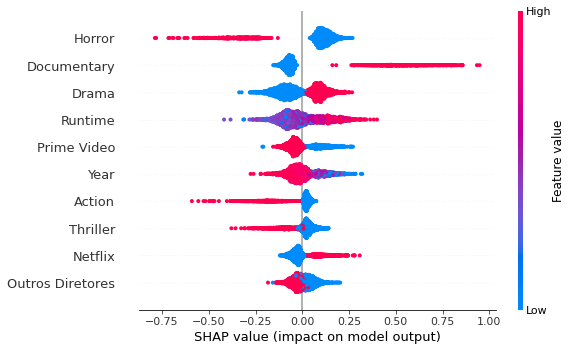

In [64]:
shap.summary_plot(shap_values, X_test, max_display=10, sort=True)

# Análise por Gênero

Como uma última análise aqui, visto os impactos e importâncias de cada feature pela análise do modelo e análise de SHAP, é interessante explorar mais a fundo os gêneros. Eles apareceram como um impacto grande na análise de SHAP e alguns ainda apresentaram uma importância razoável pela análise das features do modelo. Para tanto, foram escolhidas, de forma arbitrária, 4 gêneros para serem analisados separadamente, de forma que seja analisado quais as features mais importantes para dado gênero. De forma mais simples, o que os fãs de comédia, por exemplo, prezam mais na hora de avaliar o filme?

In [76]:
dropped_genres = ["Thriller", "Documentary", "Crime", "Adventure", "Family", "Mystery", "Sci-Fi", "Fantasy", "Biography", "History", "Animation", "Music", "War", "Western", "Musical", "Sport", "Short", "News", "Film-Noir", "Reality-TV", "Talk-Show", "Game-Show"]
selected_genres = ["Action", "Drama", "Romance", "Comedy"]
rating_db_p = rating_db_OHE.copy()
rating_db_p = rating_db_p.drop(columns = dropped_genres)

rating_db_action = rating_db_p.drop(columns=["Drama", "Romance", "Comedy","Horror"])
rating_db_drama = rating_db_p.drop(columns=["Action", "Romance", "Comedy","Horror"])
rating_db_romance = rating_db_p.drop(columns=["Action", "Drama", "Comedy","Horror"])
rating_db_comedy = rating_db_p.drop(columns=["Action", "Romance", "Drama","Horror"])
rating_db_terror = rating_db_p.drop(columns=["Action", "Romance", "Drama","Comedy"])


# Função para calcular a importância de um gênero
def feature_importance_by_genre(database, model):
    
    # Separação dos conjuntos treinamento e teste
    train_set_p, test_set_p = train_test_split(
    database,
    test_size=0.2,
    random_state=RANDOM_SEED)
    
    X_train_p = train_set_p.drop(columns=["IMDb"])
    y_train_p = train_set_p["IMDb"]
    
    model.fit(X_train_p, y_train_p)
    feature_importances =model.feature_importances_
    attributes = X_train_p.columns
    
    return sorted(zip(feature_importances, attributes), reverse=True)

In [72]:
print("Análise para o gênero Ação:")
feature_importance_by_genre(rating_db_action,model)

Análise para o gênero Ação:


[(0.22387372508987616, 'Runtime'),
 (0.16824864878712406, 'Year'),
 (0.03026072073873447, 'Action'),
 (0.020367032556979123, '18+'),
 (0.017777232232836476, 'Prime Video'),
 (0.013846179044713108, 'Outros Diretores'),
 (0.013629006623855232, 'Netflix'),
 (0.01297090984048837, 'United States'),
 (0.012623724333457246, 'English'),
 (0.007686186521691731, 'United Kingdom'),
 (0.007335897366838827, '7+'),
 (0.006126795800059749, '13+'),
 (0.005961170916079734, 'Canada'),
 (0.005154268163502224, 'French'),
 (0.004971560384955222, 'all'),
 (0.004519022220369518, 'Hulu'),
 (0.004510732142536327, 'France'),
 (0.004509238675192508, 'India'),
 (0.004475995633816343, 'Spanish'),
 (0.004337755908361869, 'Disney+'),
 (0.0040148900980062725, '16+'),
 (0.003924092284309064, 'David DeCoteau'),
 (0.0035118181078811475, 'Germany'),
 (0.003473612094201708, 'Hindi'),
 (0.0033539407865356384, 'Italy'),
 (0.002954646050104944, 'German'),
 (0.002830459349153883, 'Australia'),
 (0.0027655162973596547, 'Japane

In [73]:
print("Análise para o gênero Drama:")
feature_importance_by_genre(rating_db_drama,model)

Análise para o gênero Drama:


[(0.22730402415254997, 'Runtime'),
 (0.17067165229995493, 'Year'),
 (0.023190945399101392, '18+'),
 (0.021718690897049493, 'Drama'),
 (0.018655255824176955, 'Prime Video'),
 (0.013850810213547723, 'Outros Diretores'),
 (0.013842795017045018, 'Netflix'),
 (0.013100135055621657, 'United States'),
 (0.012050471825263328, 'English'),
 (0.007780270949953117, 'United Kingdom'),
 (0.007568034282501184, '7+'),
 (0.006228185198876678, 'Canada'),
 (0.006077911489588652, '13+'),
 (0.005074535079889037, 'all'),
 (0.004951034597700059, 'French'),
 (0.004808670346150225, 'Hulu'),
 (0.004487739855057444, 'France'),
 (0.004329923395829052, 'Spanish'),
 (0.004034856886336396, 'India'),
 (0.0039831841957328916, '16+'),
 (0.003980101095260631, 'Disney+'),
 (0.0036710672284363233, 'David DeCoteau'),
 (0.0036213126124214614, 'Germany'),
 (0.003214610488140225, 'Hindi'),
 (0.003080978351200657, 'Italy'),
 (0.0028917602454466935, 'German'),
 (0.002784288525697878, 'Mark Atkins'),
 (0.002770149814856259, 'Aus

In [74]:
print("Análise para o gênero Comédia:")
feature_importance_by_genre(rating_db_comedy,model)

Análise para o gênero Comédia:


[(0.23186274009452798, 'Runtime'),
 (0.17097951432766148, 'Year'),
 (0.022092803072162503, '18+'),
 (0.017029605501081978, 'Prime Video'),
 (0.015368603631917657, 'Comedy'),
 (0.013984408635580828, 'Netflix'),
 (0.0137353396592241, 'Outros Diretores'),
 (0.012765749304506236, 'United States'),
 (0.012200983222494943, 'English'),
 (0.007823702959861536, 'United Kingdom'),
 (0.00731966735013014, '7+'),
 (0.006519292481760257, 'Canada'),
 (0.006351998462995617, '13+'),
 (0.005240691863897708, 'all'),
 (0.005193790245560245, 'French'),
 (0.00476749159050452, 'Hulu'),
 (0.004600786565187219, 'France'),
 (0.004316377157058675, 'Spanish'),
 (0.0041635481286574315, 'Disney+'),
 (0.0040358447074603536, 'India'),
 (0.0038614250117764244, '16+'),
 (0.0038191354420329705, 'David DeCoteau'),
 (0.0035136050086170888, 'Germany'),
 (0.0032882207027835997, 'Hindi'),
 (0.0032140011655739232, 'Italy'),
 (0.0030424281478391014, 'German'),
 (0.002953907021194508, 'Mark Atkins'),
 (0.0028186983208268886, 'A

In [75]:
print("Análise para o gênero Romance:")
feature_importance_by_genre(rating_db_romance,model)

Análise para o gênero Romance:


[(0.2299784439759969, 'Runtime'),
 (0.1716428865225118, 'Year'),
 (0.021726921146035794, '18+'),
 (0.018286629580999116, 'Prime Video'),
 (0.013956566185264902, 'Outros Diretores'),
 (0.01338621452177623, 'Netflix'),
 (0.012237515402572391, 'United States'),
 (0.011909747027953553, 'English'),
 (0.009134582909358405, 'Romance'),
 (0.007903632058263768, 'United Kingdom'),
 (0.007392406967375326, '7+'),
 (0.006116687076707579, '13+'),
 (0.006016864636965393, 'Canada'),
 (0.00507374007056943, 'all'),
 (0.00503424770235063, 'French'),
 (0.0047714607206725814, 'France'),
 (0.004657942722066222, 'Hulu'),
 (0.0043143359470912464, 'Disney+'),
 (0.004242727254029616, 'India'),
 (0.004236755770448707, 'Spanish'),
 (0.0037949622409292065, 'David DeCoteau'),
 (0.003643913487784523, 'Germany'),
 (0.0035540762225948074, '16+'),
 (0.003312353636815111, 'Hindi'),
 (0.0031659162217294013, 'Italy'),
 (0.0031078992444234406, 'Mark Atkins'),
 (0.002963210731907528, 'German'),
 (0.002800203165868686, 'Aust

In [78]:
print("Análise para o gênero Terror:")
feature_importance_by_genre(rating_db_terror,model)

Análise para o gênero Terror:


[(0.20592589202358078, 'Runtime'),
 (0.1558574372281505, 'Year'),
 (0.08792929231743614, 'Horror'),
 (0.018841118088387353, '18+'),
 (0.015933653122187474, 'Prime Video'),
 (0.013082765624548225, 'Outros Diretores'),
 (0.01298922455197823, 'Netflix'),
 (0.011631283608255293, 'United States'),
 (0.011272601012671772, 'English'),
 (0.00753645856599571, 'United Kingdom'),
 (0.006931885751495367, '7+'),
 (0.005844521726700579, '13+'),
 (0.005762625941116005, 'Canada'),
 (0.004912088736864793, 'French'),
 (0.004736842738369248, 'all'),
 (0.004674814824100564, 'Hulu'),
 (0.0044920657415673595, 'France'),
 (0.004224441598394, 'India'),
 (0.003934040914537615, 'Spanish'),
 (0.0035748558243523226, 'Disney+'),
 (0.0035597154069886994, '16+'),
 (0.003298640800645795, 'David DeCoteau'),
 (0.0031660674729411453, 'Germany'),
 (0.002968075159195274, 'Hindi'),
 (0.0029645271714922694, 'German'),
 (0.0029091624872075645, 'Italy'),
 (0.002747283152251173, 'Mark Atkins'),
 (0.0027321178274238083, 'Austra

* Breve storytelling da persona por trás do projeto
* Apresentar o modelo de cabo a rabo - iniciar com o cross_val, e resultados. Predict no test
* SHAP
* Appeal para ML - se retirarmos a coluna mais eficiente, como afeta no desempenho do regressor?
* Análise exploratória - fãs de tais gêneros - o que valorizam mais?

# Conclusão

O modelo de regressor construído apresentou um resultado razoavelmente bom, permitindo ainda a análise de algumas features que contribuem ou não para a avaliação da nota IMDb do filme. O modelo ainda pode ser mais refinado utilizando outros hiperparâmetros e iterando com o auxílio do `GridSearchCV`. Como uma futura iteração, ainda pode-se implementar um modelo mais robusto e complexo, partindo para técnicas de aprendizado profundo e o uso de redes neurais.